# Random Forest

## Start Spark Session

In [1]:
import boto3
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Window

spark = SparkSession.builder \
    .appName("Inference") \
    .getOrCreate()

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.7 
Trying to create a Glue session for the kernel.
Session Type: etl
Session ID: e8af09bb-2f07-47a8-bdea-6e9c49e16d88
Applying the following default arguments:
--glue_kernel_version 1.0.7
--enable-glue-datacatalog true
Waiting for session e8af09bb-2f07-47a8-bdea-6e9c49e16d88 to get into ready status...
Session e8af09bb-2f07-47a8-bdea-6e9c49e16d88 has been created.



In [2]:
%session_id 

Current active Session ID: e8af09bb-2f07-47a8-bdea-6e9c49e16d88


## Set up Model

In [2]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, lag
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# Load data
bucket_name = "crypto-marketdata-marketdatabucket-m13jkiz8o4p7"
btc_processed_file_path = "s3://{}/marketdata/processed_crypto/BTCUSDT-*-processed.parquet".format(bucket_name)

btc_processed_data = spark.read.parquet(btc_processed_file_path)
btc_processed_data = btc_processed_data.orderBy("close_time")

In [11]:
# Create the label (Next Close)
window = Window.orderBy("close_time")
btc_data_with_label = btc_processed_data.withColumn("Next_Close", F.lead("close").over(window))

In [12]:
# Drop rows with null values
btc_data_with_label = btc_data_with_label.dropna()

In [13]:
btc_data_with_label.columns

['close_time', 'open_time', 'open', 'high', 'low', 'close', 'vol', 'quote_asset_vol', 'number_of_trades', 'taker_base_asset_vol', 'taker_quote_asset_vol', 'ignore', 'ticker', 'SMA_240', 'SMA_480', 'RSI', 'Middle_Band', 'STD', 'Upper_Band', 'Lower_Band', 'Next_Close']


#### Train the model

In [20]:
# Prepare features and label

features = ['open', 'high', 'low', 'vol', 'quote_asset_vol', 
            'number_of_trades', 'taker_base_asset_vol', 
            'taker_quote_asset_vol', 'SMA_240', 'SMA_480', 'RSI', 
            'Middle_Band', "STD", "Upper_Band", "Lower_Band"]

assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(btc_data_with_label).select("close_time", "features", "Next_Close")

In [21]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=4651)

In [22]:
# Create and train the Random Forest model
rf = RandomForestRegressor(labelCol="Next_Close", numTrees=100)
rf_model = rf.fit(train_data)

In [23]:
predictions = rf_model.transform(test_data)

In [25]:
predictions.select("Next_Close", "prediction").show()

+----------+------------------+
|Next_Close|        prediction|
+----------+------------------+
|  13780.41| 14834.60656650084|
|  13499.99| 14834.60656650084|
|   13022.0|14799.197519256257|
|   13135.0|14799.197519256257|
|  13240.37|14799.197519256257|
|  13399.24| 14834.60656650084|
|   13522.0| 14834.60656650084|
|  14818.49| 14834.60656650084|
|  15019.66| 14834.60656650084|
|  14455.55| 14834.60656650084|
|  14855.02| 14834.60656650084|
|  15010.06| 14834.60656650084|
|  14700.01| 14834.60656650084|
|  14926.01| 14834.60656650084|
|  15119.97| 14834.60656650084|
|   14875.1| 14834.60656650084|
|  14353.01| 14834.60656650084|
|  14648.89| 14834.60656650084|
|  14906.01| 14834.60656650084|
|  14965.37| 14834.60656650084|
+----------+------------------+
only showing top 20 rows


#### Result evaluation

In [34]:
# Evaluate the predictions
evaluator = RegressionEvaluator(labelCol="Next_Close", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Root Mean Squared Error (RMSE):", rmse)
print("R2:", r2)

Root Mean Squared Error (RMSE): 733.1184429845566
R2: 0.9986408404032255


#### Observe the feature importance

In [30]:
# Get feature importances
feature_importances = rf_model.featureImportances

# Create a list of feature names and their corresponding coefficients
feature_names = features
results = [(feature_names[i], feature_importances[i]) for i in range(len(feature_importances))]

for feature, importance in results:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: open, Importance: 0.2568829845279969
Feature: high, Importance: 0.22825241985472347
Feature: low, Importance: 0.26880063143001703
Feature: vol, Importance: 1.8648220132301607e-06
Feature: quote_asset_vol, Importance: 2.0532676932836607e-06
Feature: number_of_trades, Importance: 1.1903576876622419e-05
Feature: taker_base_asset_vol, Importance: 5.704844290116192e-05
Feature: taker_quote_asset_vol, Importance: 8.758182261474584e-06
Feature: SMA_240, Importance: 0.10179895597589139
Feature: SMA_480, Importance: 0.06022820524757253
Feature: RSI, Importance: 0.00012968219120707607
Feature: Middle_Band, Importance: 0.04890220151377826
Feature: STD, Importance: 4.158213924054193e-05
Feature: Upper_Band, Importance: 0.01649020754069882
Feature: Lower_Band, Importance: 0.018391501287128072


#### Plot the prediction vs actual close price

In [31]:
predictions_pd = predictions.toPandas()

In [32]:
predictions_pd.tail(1)

                   close_time  ...    prediction
11836 2024-10-31 22:59:59.999  ...  69193.830935

[1 rows x 4 columns]


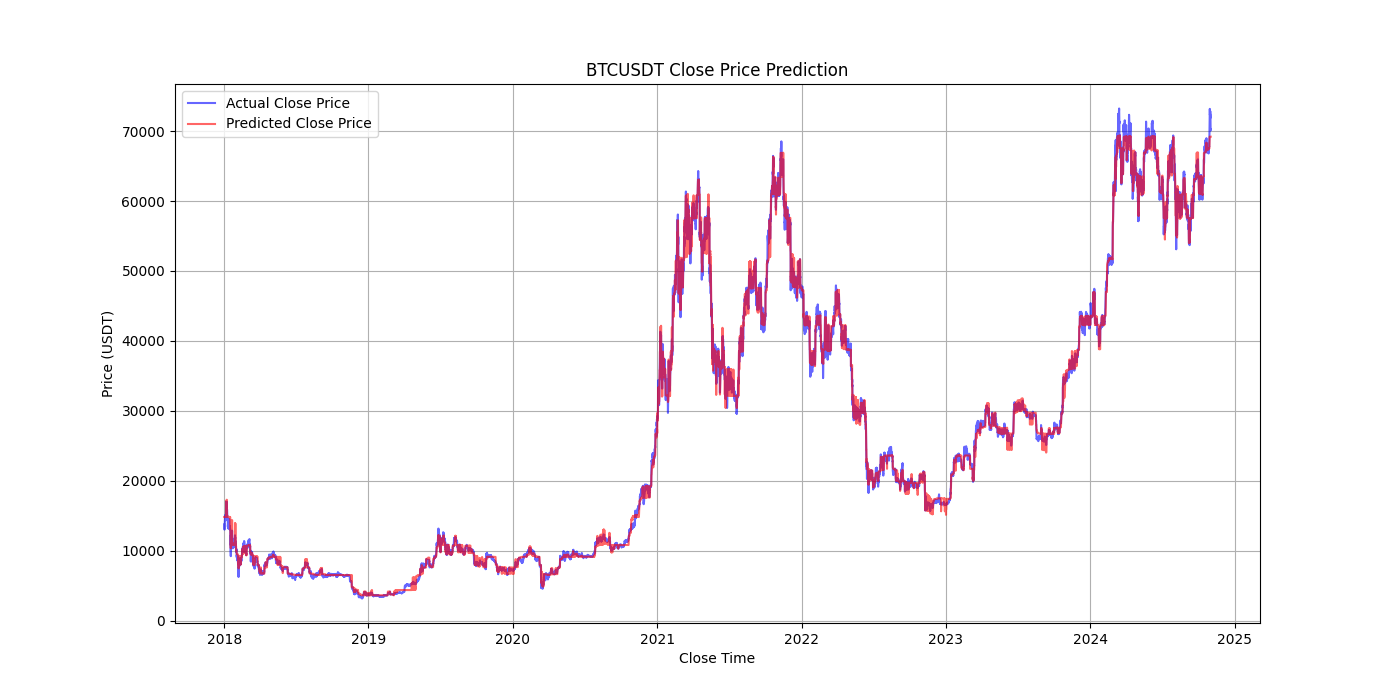

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(predictions_pd["close_time"], predictions_pd["Next_Close"].values, label="Actual Close Price", color="blue", alpha=0.6)
plt.plot(predictions_pd["close_time"], predictions_pd["prediction"].values, label="Predicted Close Price", color="red", alpha=0.6)
plt.title("BTCUSDT Close Price Prediction")
plt.xlabel("Close Time")
plt.ylabel("Price (USDT)")
plt.legend()
plt.grid()
plt.show()

%matplot plt

In [7]:
%stop_session

Stopping session: 8e92cea8-3a53-4b03-b631-0eb328b04bd9
Stopped session.
